In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.utils.parametrize as parametrize
from tqdm import tqdm

## Hyperparameters

In [2]:
BATCH_SIZE = 200

TEST_SIZE = 0.2

N_EPOCH = 20
LEARNING_RATES = 0.001

torch.manual_seed(689)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Dataset preparations

In [3]:
from automata import *
from datas import principal

In [4]:
even, sink, fix, unique = principal()

Generate dataset 'even'...
Done! in 4.0022 sec
Generate dataset 'sink'...
Done! in 38.7018 sec
Generate 'fix'...
Done! in 5.4634 sec
Generate 'unique'...
Done! in 4.7610 sec


In [5]:
def makeloader(automaton:DFA):
    train, test = random_split(TorchData(automaton), [1-TEST_SIZE, TEST_SIZE])

    train = DataLoader(train, BATCH_SIZE, shuffle=True)
    test = next(iter(DataLoader(test, len(test))))

    return train, test
    

evenloader, testeven = makeloader(even)

sinkloader, testsink = makeloader(sink)

In [5]:
torch.sum(testsink[2])/len(testsink[2])

tensor(0.5040)

## RNN training

In [6]:
class AutomataRNN(nn.Module):

    def __init__(self, automaton:DFA) -> None:
        super().__init__()
        self.automaton = automaton
        self.transshape = automaton.transition.shape
        self.hidden_size = self.transshape[0]*self.transshape[1]

        self.rnn = nn.RNN(self.transshape[1], self.hidden_size, num_layers=1, batch_first=True, device=device, bias=False)
        self.toclass = nn.Linear(self.hidden_size, 2, device=device, bias=False)

    def absinit(self):
        "Force the sign of the initial parameters to be in the desired shape."
        parameters = {"rnn.weight_ih_l0" : abs(self.state_dict()["rnn.weight_ih_l0"]),
                      "rnn.weight_hh_l0" : -abs(self.state_dict()["rnn.weight_hh_l0"]),
                      "toclass.weight" :  abs(self.state_dict()["toclass.weight"])}
        
        self.load_state_dict(parameters)    

    def forward(self, x, truelen):
        "`truelen` is a list of the real length of the sequence : that way we can recover the good prediction along the rnn"
        h0 = torch.zeros(1, x.shape[0], self.hidden_size).to(device)
        h0[:,:,0] = 1
        out, _ = self.rnn(x.to(device), h0)
        out = torch.stack([out[i, truelen[i] -1, :] for i in range(out.shape[0])]) #extract only the require prediction y for each batch
        return self.toclass(out)
        
    def predict(self, x, truelen):
        return torch.argmax(self(x, truelen), dim = 1)
    
    def strpredict(self, word:str):
        tensor = torch.tensor(self.automaton.word_to_matrix(word))
        return 

In [7]:
class HiddentoHidden(nn.Module):
    def __init__(self, RNN) -> None:
        super().__init__()
        self.transshape = RNN.transshape
        self.hidden_size = RNN.hidden_size

    def forward(self, X):
        "X is a square matrix of the size of the hidden vector."
        cat = [X[:,i].reshape(-1,1).expand(-1, self.transshape[1])  for i in range(0, self.hidden_size, self.transshape[1])]
        return torch.cat(cat, dim=1)
        

class ParametrizeRNN(AutomataRNN):
    """
    RNN with parameters with the constraints find by volodimir for automata.
    """
    def __init__(self, automaton: DFA) -> None:
        super().__init__(automaton)
        statedict = self.state_dict()
        weight_hh = torch.zeros(*statedict["rnn.weight_hh_l0"].shape)
        for i in range(0, self.hidden_size, self.transshape[1]):
            weight_hh[:,i] = statedict["rnn.weight_hh_l0"][:,i]
            statedict["rnn.weight_ih_l0"][i:i+self.transshape[1]] = 2*torch.eye(self.transshape[1])
        statedict["rnn.weight_hh_l0"] = weight_hh
        self.load_state_dict(statedict)
        self.rnn.all_weights[0][0].requires_grad_(False) # turn off the optimization along weight_ih

        parametrize.register_parametrization(self.rnn, "weight_hh_l0", HiddentoHidden(self))

In [25]:
def parametrizevsnot(automaton:DFA, loss = nn.CrossEntropyLoss(), optimizer = torch.optim.Adam, returnautomat=False):
    trainloader, test = makeloader(automaton)

    noparam = AutomataRNN(automaton).to(device)
    optim = optimizer(noparam.parameters(), lr=LEARNING_RATES)

    losslistnoinit = list()

    for epoch in range(N_EPOCH):
        trainer = iter(trainloader)
        for _ in tqdm(range(len(trainloader)), desc=f"Epoch {epoch+1}...", ncols=75):
            words, lengths, labels = next(trainer)

            out = noparam(words, lengths)

            losslistnoinit.append(loss(out, labels))
            losslistnoinit[-1].backward()

            optim.step()
            optim.zero_grad()

        with torch.no_grad():
            predictions = noparam.predict(test[0], test[1])
            acc = torch.sum(predictions == test[2].reshape(-1), dim=0) * 100 / len(test[2])
            print(f"Done! Trainloss: {losslistnoinit[-1]:.6f}, Test accuracy: {acc:.4f}")

    print("\nNon parametrized RNN done!\n")

    withparam = ParametrizeRNN(automaton).to(device)

    optim = optimizer(withparam.parameters(), lr=LEARNING_RATES)

    losslistinit = list()

    for epoch in range(N_EPOCH):
        trainer = iter(trainloader)
        for _ in tqdm(range(len(trainloader)), desc=f"Epoch {epoch+1}...", ncols=75):
            words, lengths, labels = next(trainer)

            out = withparam(words, lengths)

            losslistinit.append(loss(out, labels))
            losslistinit[-1].backward()

            optim.step()
            optim.zero_grad()

        with torch.no_grad():
            predictions = withparam.predict(test[0], test[1])
            acc = torch.sum(predictions == test[2].reshape(-1), dim=0) * 100 / len(test[2])
            print(f"Done! Trainloss: {losslistinit[-1]:.6f}, Test accuracy: {acc:.4f}")

    print("\nParametrized RNN done!")
    if returnautomat:
        return (losslistnoinit, noparam), (losslistinit, withparam)
    else:
        return losslistnoinit, losslistinit
            

### Even

In [9]:
evennop, evenp = parametrizevsnot(even)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:00<00:00, 42.86it/s]


Done! Trainloss: 0.707031, Test accuracy: 49.1500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 38.05it/s]


Done! Trainloss: 0.702462, Test accuracy: 49.3500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:00<00:00, 45.07it/s]


Done! Trainloss: 0.692792, Test accuracy: 48.7500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:00<00:00, 43.71it/s]


Done! Trainloss: 0.694851, Test accuracy: 48.8500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:00<00:00, 48.30it/s]


Done! Trainloss: 0.691871, Test accuracy: 48.8500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:00<00:00, 45.06it/s]


Done! Trainloss: 0.697111, Test accuracy: 48.7000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:00<00:00, 44.45it/s]


Done! Trainloss: 0.694811, Test accuracy: 48.7500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:00<00:00, 42.74it/s]


Done! Trainloss: 0.695082, Test accuracy: 48.3500


Epoch 9...: 100%|██████████████████████████| 40/40 [00:00<00:00, 46.03it/s]


Done! Trainloss: 0.691124, Test accuracy: 48.6500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:00<00:00, 47.08it/s]


Done! Trainloss: 0.693520, Test accuracy: 48.4000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.69it/s]


Done! Trainloss: 0.694933, Test accuracy: 48.6500


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 38.60it/s]


Done! Trainloss: 0.692943, Test accuracy: 49.9500


Epoch 13...: 100%|█████████████████████████| 40/40 [00:00<00:00, 47.94it/s]


Done! Trainloss: 0.692414, Test accuracy: 49.6500


Epoch 14...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.05it/s]


Done! Trainloss: 0.693632, Test accuracy: 48.8000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:00<00:00, 45.86it/s]


Done! Trainloss: 0.693237, Test accuracy: 48.6500


Epoch 16...: 100%|█████████████████████████| 40/40 [00:00<00:00, 47.81it/s]


Done! Trainloss: 0.693106, Test accuracy: 48.8500


Epoch 17...: 100%|█████████████████████████| 40/40 [00:00<00:00, 47.45it/s]


Done! Trainloss: 0.692901, Test accuracy: 48.7500


Epoch 18...: 100%|█████████████████████████| 40/40 [00:00<00:00, 42.83it/s]


Done! Trainloss: 0.692739, Test accuracy: 49.9000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:00<00:00, 43.99it/s]


Done! Trainloss: 0.692663, Test accuracy: 48.9000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:00<00:00, 42.83it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.5000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:00<00:00, 40.44it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.8000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:00<00:00, 45.90it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.8000


Epoch 3...: 100%|██████████████████████████| 40/40 [00:00<00:00, 45.32it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.8000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.23it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.9500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.24it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.4500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:00<00:00, 41.60it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.7000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.37it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.6000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 39.71it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.0000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 36.74it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.0500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:00<00:00, 42.10it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:00<00:00, 42.05it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.3500


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 39.83it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.4000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 36.41it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.1000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:00<00:00, 45.43it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.8500


Epoch 15...: 100%|█████████████████████████| 40/40 [00:00<00:00, 42.51it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.3500


Epoch 16...: 100%|█████████████████████████| 40/40 [00:00<00:00, 50.16it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.0500


Epoch 17...: 100%|█████████████████████████| 40/40 [00:00<00:00, 41.53it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.4000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 35.04it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.8500


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 38.75it/s]


Done! Trainloss: 0.692700, Test accuracy: 50.6500


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 31.05it/s]


Done! Trainloss: 0.692700, Test accuracy: 49.4000

Parametrized RNN done!


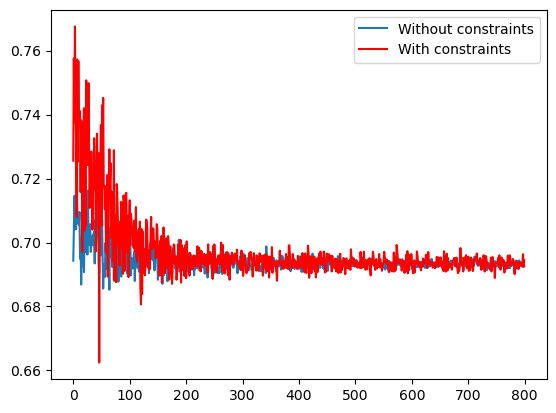

In [14]:
with torch.no_grad():
    plt.plot(evennop, label = "Without constraints")
    plt.plot(evenp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

### Sink

In [19]:
(sinknop, sinkRNN), (sinkp, _) = parametrizevsnot(sink, returnautomat=True)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.64it/s]


Done! Trainloss: 0.636755, Test accuracy: 66.1500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.34it/s]


Done! Trainloss: 0.513982, Test accuracy: 87.8500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.97it/s]


Done! Trainloss: 0.357686, Test accuracy: 92.6000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.32it/s]


Done! Trainloss: 0.256723, Test accuracy: 99.3000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.65it/s]


Done! Trainloss: 0.177600, Test accuracy: 100.0000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.07it/s]


Done! Trainloss: 0.132778, Test accuracy: 100.0000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.47it/s]


Done! Trainloss: 0.099441, Test accuracy: 100.0000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.45it/s]


Done! Trainloss: 0.084540, Test accuracy: 100.0000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.05it/s]


Done! Trainloss: 0.067658, Test accuracy: 100.0000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.07it/s]


Done! Trainloss: 0.054356, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.96it/s]


Done! Trainloss: 0.040657, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.40it/s]


Done! Trainloss: 0.033858, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.72it/s]


Done! Trainloss: 0.029050, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.27it/s]


Done! Trainloss: 0.031387, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.51it/s]


Done! Trainloss: 0.034508, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.74it/s]


Done! Trainloss: 0.019761, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 22.02it/s]


Done! Trainloss: 0.020327, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 23.81it/s]


Done! Trainloss: 0.012532, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.92it/s]


Done! Trainloss: 0.012972, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.98it/s]


Done! Trainloss: 0.021465, Test accuracy: 100.0000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.10it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.05it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 35.04it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 36.64it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 36.87it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.4500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.74it/s]


Done! Trainloss: 0.021465, Test accuracy: 90.5000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.56it/s]


Done! Trainloss: 0.021465, Test accuracy: 93.8500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 37.18it/s]


Done! Trainloss: 0.021465, Test accuracy: 96.6000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 36.68it/s]


Done! Trainloss: 0.021465, Test accuracy: 95.7500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 37.54it/s]


Done! Trainloss: 0.021465, Test accuracy: 96.3000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 38.10it/s]


Done! Trainloss: 0.021465, Test accuracy: 97.2000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 37.00it/s]


Done! Trainloss: 0.021465, Test accuracy: 97.3000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.99it/s]


Done! Trainloss: 0.021465, Test accuracy: 97.4000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 37.09it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.2500


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.89it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.3500


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 21.53it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.7000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.08it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.9000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.22it/s]


Done! Trainloss: 0.021465, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.44it/s]


Done! Trainloss: 0.021465, Test accuracy: 99.9000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.57it/s]


Done! Trainloss: 0.021465, Test accuracy: 100.0000

Parametrized RNN done!


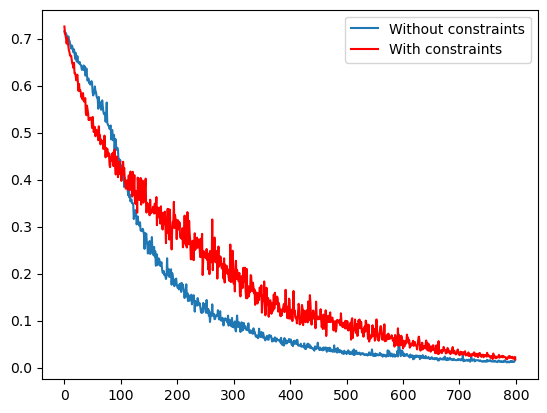

In [20]:
with torch.no_grad():
    plt.plot(sinknop, label = "Without constraints")
    plt.plot(sinkp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

In [21]:
sink.probas = "equal"

sink.dataset(10000, meanlen = 12, max_try = 10000, random_state=690)

sinkmoretest = next(iter(DataLoader(TorchData(sink), 10000)))

with torch.no_grad():
    predictions = sinkRNN.predict(sinkmoretest[0], sinkmoretest[1])
    acc = torch.sum(predictions == sinkmoretest[2].reshape(-1), dim=0) * 100 / len(sinkmoretest[2])
    print(f"Test accuracy: {acc:.4f}")

/home/mt-ubu2/Documents/Internship/RNN_autmata/automata.py:325: UserWarning: `max_try` limit reach. Final prop = 0.0002
  warn(f"`max_try` limit reach. Final prop = {sum(labels)/len(labels)}")


Test accuracy: 98.3000


## Fix

In [26]:
fixnop, fixp = parametrizevsnot(fix)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.03it/s]


Done! Trainloss: 0.461476, Test accuracy: 85.0000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.12it/s]


Done! Trainloss: 0.214720, Test accuracy: 92.9500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.88it/s]


Done! Trainloss: 0.129815, Test accuracy: 99.2000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.71it/s]


Done! Trainloss: 0.073918, Test accuracy: 100.0000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.94it/s]


Done! Trainloss: 0.027627, Test accuracy: 100.0000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 35.28it/s]


Done! Trainloss: 0.012418, Test accuracy: 100.0000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.21it/s]


Done! Trainloss: 0.014078, Test accuracy: 100.0000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.87it/s]


Done! Trainloss: 0.008011, Test accuracy: 100.0000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.84it/s]


Done! Trainloss: 0.006931, Test accuracy: 100.0000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 35.40it/s]


Done! Trainloss: 0.004999, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.79it/s]


Done! Trainloss: 0.004697, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.77it/s]


Done! Trainloss: 0.004499, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 31.03it/s]


Done! Trainloss: 0.003876, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 35.78it/s]


Done! Trainloss: 0.002447, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.98it/s]


Done! Trainloss: 0.002586, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.16it/s]


Done! Trainloss: 0.002048, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.52it/s]


Done! Trainloss: 0.003151, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.66it/s]


Done! Trainloss: 0.001554, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 35.42it/s]


Done! Trainloss: 0.001881, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.89it/s]


Done! Trainloss: 0.001496, Test accuracy: 100.0000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.60it/s]


Done! Trainloss: 0.689057, Test accuracy: 59.7500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.34it/s]


Done! Trainloss: 0.517337, Test accuracy: 75.7500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.47it/s]


Done! Trainloss: 0.259318, Test accuracy: 94.2500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.98it/s]


Done! Trainloss: 0.158872, Test accuracy: 94.9500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.89it/s]


Done! Trainloss: 0.158492, Test accuracy: 96.4000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.44it/s]


Done! Trainloss: 0.120825, Test accuracy: 95.3000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.12it/s]


Done! Trainloss: 0.111034, Test accuracy: 97.4500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.86it/s]


Done! Trainloss: 0.115457, Test accuracy: 97.2000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.39it/s]


Done! Trainloss: 0.056206, Test accuracy: 97.9500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 35.12it/s]


Done! Trainloss: 0.064984, Test accuracy: 98.6500


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.56it/s]


Done! Trainloss: 0.059156, Test accuracy: 99.1000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.16it/s]


Done! Trainloss: 0.033045, Test accuracy: 99.4500


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.52it/s]


Done! Trainloss: 0.017911, Test accuracy: 99.8000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 25.83it/s]


Done! Trainloss: 0.039887, Test accuracy: 99.7000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.81it/s]


Done! Trainloss: 0.020275, Test accuracy: 99.9000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.40it/s]


Done! Trainloss: 0.011266, Test accuracy: 99.8000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.65it/s]


Done! Trainloss: 0.007725, Test accuracy: 99.9000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.76it/s]


Done! Trainloss: 0.009491, Test accuracy: 99.9000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.65it/s]


Done! Trainloss: 0.006652, Test accuracy: 99.9000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.14it/s]


Done! Trainloss: 0.005516, Test accuracy: 99.9000

Parametrized RNN done!


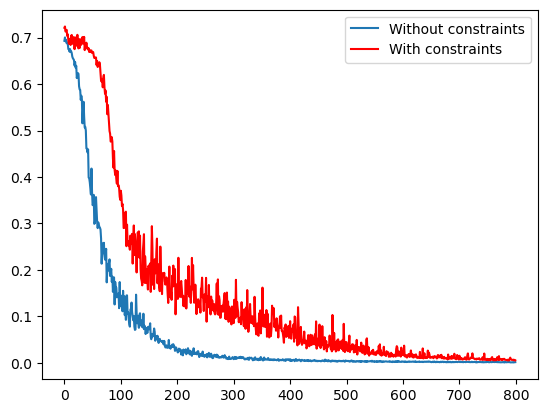

In [27]:
with torch.no_grad():
    plt.plot(fixnop, label = "Without constraints")
    plt.plot(fixp, "r", label="With constraints")
    plt.legend()
    plt.show()
    

## Unique

In [28]:
uniquenop, uniquep = parametrizevsnot(unique)

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.38it/s]


Done! Trainloss: 0.692302, Test accuracy: 55.4000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 28.06it/s]


Done! Trainloss: 0.694669, Test accuracy: 45.2500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.65it/s]


Done! Trainloss: 0.693985, Test accuracy: 43.7000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.94it/s]


Done! Trainloss: 0.692724, Test accuracy: 47.6000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.59it/s]


Done! Trainloss: 0.696047, Test accuracy: 45.6500


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 28.59it/s]


Done! Trainloss: 0.685879, Test accuracy: 48.8000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.94it/s]


Done! Trainloss: 0.542805, Test accuracy: 73.5500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 28.00it/s]


Done! Trainloss: 0.483421, Test accuracy: 78.7500


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.52it/s]


Done! Trainloss: 0.431667, Test accuracy: 78.4000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.82it/s]


Done! Trainloss: 0.345195, Test accuracy: 90.6500


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.60it/s]


Done! Trainloss: 0.308816, Test accuracy: 91.8000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.72it/s]


Done! Trainloss: 0.200303, Test accuracy: 92.1000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.95it/s]


Done! Trainloss: 0.212477, Test accuracy: 93.1000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.77it/s]


Done! Trainloss: 0.202708, Test accuracy: 93.6000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.55it/s]


Done! Trainloss: 0.156117, Test accuracy: 94.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.78it/s]


Done! Trainloss: 0.166886, Test accuracy: 93.7500


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.10it/s]


Done! Trainloss: 0.148625, Test accuracy: 94.2000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.15it/s]


Done! Trainloss: 0.149871, Test accuracy: 94.6500


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.52it/s]


Done! Trainloss: 0.125958, Test accuracy: 94.9500


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 27.61it/s]


Done! Trainloss: 0.122947, Test accuracy: 95.1000

Non parametrized RNN done!



Epoch 1...: 100%|██████████████████████████| 40/40 [00:02<00:00, 19.41it/s]


Done! Trainloss: 0.692298, Test accuracy: 50.4000


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.19it/s]


Done! Trainloss: 0.667874, Test accuracy: 58.6500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.81it/s]


Done! Trainloss: 0.620869, Test accuracy: 61.7000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.24it/s]


Done! Trainloss: 0.451569, Test accuracy: 71.6000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.72it/s]


Done! Trainloss: 0.334467, Test accuracy: 84.5000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.11it/s]


Done! Trainloss: 0.263616, Test accuracy: 83.9000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 28.00it/s]


Done! Trainloss: 0.207419, Test accuracy: 84.2000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.96it/s]


Done! Trainloss: 0.232390, Test accuracy: 95.9500


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.55it/s]


Done! Trainloss: 0.159696, Test accuracy: 96.4000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 28.34it/s]


Done! Trainloss: 0.146829, Test accuracy: 96.2000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.79it/s]


Done! Trainloss: 0.172944, Test accuracy: 97.2000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.70it/s]


Done! Trainloss: 0.185170, Test accuracy: 94.2000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.70it/s]


Done! Trainloss: 0.680825, Test accuracy: 82.9500


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.12it/s]


Done! Trainloss: 0.404837, Test accuracy: 87.1000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.28it/s]


Done! Trainloss: 0.370903, Test accuracy: 90.2000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.67it/s]


Done! Trainloss: 0.333264, Test accuracy: 91.8500


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.24it/s]


Done! Trainloss: 0.262888, Test accuracy: 92.9000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.76it/s]


Done! Trainloss: 0.235336, Test accuracy: 94.0500


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 26.01it/s]


Done! Trainloss: 0.198701, Test accuracy: 94.6500


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.17it/s]


Done! Trainloss: 0.210070, Test accuracy: 95.0500

Parametrized RNN done!


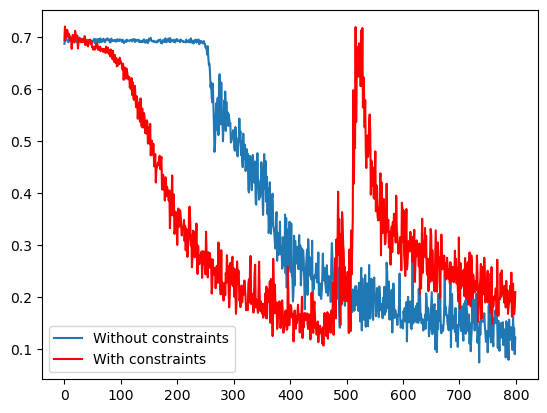

In [29]:
with torch.no_grad():
    plt.plot(uniquenop, label = "Without constraints")
    plt.plot(uniquep, "r", label="With constraints")
    plt.legend()
    plt.show()
    